# Estimation des tailles d'échantillons réalistes

In [360]:
import codecs,math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
from datetime import datetime

### Routines de formatages des axes matplotlib

In [308]:
def reFormatTicks(x,pos):
    text="0"
    if x!=0:
        magnitude=int(np.log10(x))
        x=round(float(x)/(10**magnitude),1)*10**magnitude
        if magnitude>=9:
            unit="G"
            value=("%.1f"%(float(x)/1e9)).strip("0").strip(".")
        elif magnitude>=6:
            unit="M"
            value=("%.1f"%(float(x)/1e6)).strip("0").strip(".")
        elif magnitude>=3:
            unit="k"
            value=("%.1f"%(float(x)/1e3)).strip("0").strip(".")
        else:
            unit=""
            value=("%.1f"%float(x)).strip("0").strip(".")
        text="%s%s"%(value,unit)
    return text

def Mois2Annees(x,pos):
    return int(x/12)


## Lecture de Lexique3
1. lecture dans un DF *Lexique3*
1. extraction des colonnes pertinentes *lex3*

In [42]:
repHDR="/Users/gilles/ownCloud/Recherche/Boye/HDR/Memoire/"
nomLexiqueOrg="/Users/gilles/ownCloud/Python/phonemisation/Lexique380-UTF8.txt"
nomRepertoire="/Volumes/gilles/Transfert/Copies-iMac-GB/Python/phonemisation/"
nomLexiqueOrg=nomRepertoire+"Lexique380-UTF8.txt"
Lexique3=pd.read_csv(nomLexiqueOrg,sep="\t")

In [43]:
Lexique3

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,...,26_orthrenv,27_phonrenv,28_orthosyll,29_cgramortho,30_deflem,31_defobs,32_old20,33_pld20,34_morphoder,35_nbmorph
0,a,a,a,NOM,m,NaN,81.36,58.65,81.36,58.65,...,a,a,a,"NOM,AUX,VER",NaN,NaN,1.00,1.00,a,1.0
1,a,a,avoir,AUX,NaN,NaN,18559.22,12800.81,6350.91,2926.69,...,a,a,a,"NOM,AUX,VER",NaN,NaN,1.00,1.00,avoir,1.0
2,a,a,avoir,VER,NaN,NaN,13572.40,6426.49,5498.34,1669.39,...,a,a,a,"NOM,AUX,VER",93.0,16.0,1.00,1.00,avoir,1.0
3,a capella,akapEla,a capella,ADV,NaN,NaN,0.04,0.07,0.04,0.07,...,allepac a,alEpaka,a ca-pel-la,ADV,NaN,NaN,3.85,2.85,a-capella,2.0
4,a cappella,akapEla,a cappella,ADV,NaN,NaN,0.04,0.07,0.04,0.07,...,alleppac a,alEpaka,a cap-pel-la,ADV,NaN,NaN,4.60,2.85,a-cappella,2.0
5,a contrario,ak§tRaRjo,a contrario,ADV,NaN,NaN,0.00,0.27,0.00,0.27,...,oirartnoc a,ojRaRt§ka,a con-tra-rio,ADV,NaN,NaN,4.30,3.30,a-contrario,2.0
6,a fortiori,afORsjoRi,a fortiori,ADV,NaN,NaN,0.04,0.88,0.04,0.88,...,iroitrof a,iRojsROfa,a for-tio-ri,ADV,NaN,NaN,4.40,3.95,a-fortiori,2.0
7,a giorno,adZjORno,a giorno,ADV,NaN,NaN,0.00,0.27,0.00,0.27,...,onroig a,onROjZda,a gior-no,ADV,NaN,NaN,3.85,3.85,a-giorno,2.0
8,a jeun,aZ1,à jeun,ADV,NaN,NaN,1.45,3.85,0.18,0.00,...,nuej a,1Za,a jeun,ADV,NaN,NaN,2.90,1.60,à-jeun,2.0
9,a l'instar,al5staR,a l'instar,PRE,NaN,NaN,0.26,0.00,0.26,0.00,...,ratsni'l a,Rats5la,a l'ins-tar,PRE,NaN,NaN,4.80,3.00,a-l'instar,2.0


In [127]:
categories=u"verbes noms adjectifs adverbes pronoms déterminants prépositions conjonctions autres".split(" ")
cgrams={
    u"verbes":["VER","AUX"],
    u"noms":["NOM"],
    u"adjectifs":["ADJ"],
    u"adverbes":["ADV"],
    u"déterminants":['ART:def', 'ADJ:ind', 'ADJ:num', 'ADJ:dem', 'ART:ind', 'ADJ:pos', 'ADJ:int'],
    u"prépositions":["PRE"],
    u"conjonctions":["CON"],
    u"pronoms":['PRO:ind', 'PRO:int', 'PRO:rel', 'PRO:dem', 'PRO:per', 'PRO:pos'],
    u"autres":['ONO', 'LIA']
}
catLex=cgrams["verbes"]+cgrams["noms"]+cgrams["adjectifs"]+cgrams["adverbes"]
catNonLex=cgrams[u"déterminants"]+cgrams[u"prépositions"]+cgrams["conjonctions"]+cgrams["pronoms"]+cgrams["autres"]


In [45]:
Lexique3.columns

Index([u'1_ortho', u'2_phon', u'3_lemme', u'4_cgram', u'5_genre', u'6_nombre',
       u'7_freqlemfilms2', u'8_freqlemlivres', u'9_freqfilms2',
       u'10_freqlivres', u'11_infover', u'12_nbhomogr', u'13_nbhomoph',
       u'14_islem', u'15_nblettres', u'16_nbphons', u'17_cvcv', u'18_p_cvcv',
       u'19_voisorth', u'20_voisphon', u'21_puorth', u'22_puphon', u'23_syll',
       u'24_nbsyll', u'25_cv-cv', u'26_orthrenv', u'27_phonrenv',
       u'28_orthosyll', u'29_cgramortho', u'30_deflem', u'31_defobs',
       u'32_old20', u'33_pld20', u'34_morphoder', u'35_nbmorph'],
      dtype='object')

In [46]:
lex3=Lexique3[["1_ortho","2_phon","3_lemme","4_cgram","5_genre","6_nombre","7_freqlemfilms2","8_freqlemlivres","9_freqfilms2","10_freqlivres","11_infover"]].copy()

In [47]:
Lexique3=None

In [48]:
lex3.loc[:,"7_freqlemfilms2"]=lex3.loc[:,"7_freqlemfilms2"].astype(float)
lex3.loc[:,"8_freqlemlivres"]=lex3.loc[:,"8_freqlemlivres"].astype(float)
lex3.loc[:,"9_freqfilms2"]=lex3.loc[:,"9_freqfilms2"].astype(float)
lex3.loc[:,"10_freqlivres"]=lex3.loc[:,"10_freqlivres"].astype(float)
lex3[["1_ortho","3_lemme","9_freqfilms2"]].head()

,1_ortho,3_lemme,9_freqfilms2
0,a,a,81.36
1,a,avoir,6350.91
2,a,avoir,5498.34
3,a capella,a capella,0.04
4,a cappella,a cappella,0.04


### Comptages des catégories

In [594]:
proportionsCgram=[]
nbFormesCgram=[]
lex3Freqfilms2Sum=lex3["9_freqfilms2"].sum()
lex3FormFilms2Sum=lex3[lex3["9_freqfilms2"]>0]["9_freqfilms2"].count()
for c in categories:
    proportion=lex3[lex3["4_cgram"].isin(cgrams[c])]["9_freqfilms2"].sum()/lex3Freqfilms2Sum
    proportionsCgram.append([c,proportion])
    nbFormes=lex3[(lex3["4_cgram"].isin(cgrams[c]))&(lex3["9_freqfilms2"]>0)]["9_freqfilms2"].count()
    nbFormesCgram.append([c,nbFormes])

In [595]:
nbFormesCgram

[[u'verbes', 48370],
 [u'noms', 37440],
 [u'adjectifs', 20941],
 [u'adverbes', 1366],
 [u'pronoms', 161],
 [u'd\xe9terminants', 205],
 [u'pr\xe9positions', 71],
 [u'conjonctions', 35],
 [u'autres', 206]]

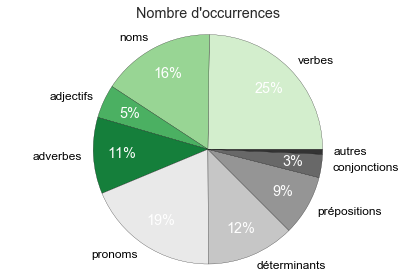

In [241]:
DFAX=pd.DataFrame(proportionsCgram,columns=["cat","prop"]).set_index("cat")
ax=DFAX.plot(kind="pie",y="prop",
             labels=DFAX.index,
             autopct=lambda p: '%1d%%'%round(p) if round(p) > 1 else '',
             pctdistance = 0.75, 
             textprops=dict(color="black",),
             colors=sns.color_palette("Greens", 4)+sns.color_palette("Greys", 5),
            )
for text in ax.texts:
    if "%" in text.get_text():
        text.set_color('white')
ax.set_title(u"Nombre d'occurrences",y=1.05)
ax.axis('equal')
ax.set(ylabel="")
ax.get_legend().remove()
#ax.legend(labels=DFAX.index,
#          title=u"Catégories",
#          loc="center right",
#          bbox_to_anchor=(.75, 0, 0.5, 1))
plt.tight_layout()
plt.savefig(repHDR+u'Lex3-FrequenceCategorie.png', dpi=300, bbox_inches="tight")
plt.show()

## Analyse de Lexique3

#### Ajout du rang pour les formes

In [535]:
lex3.loc[lex3["9_freqfilms2"]>0,"rangFW"]=lex3.loc[lex3["9_freqfilms2"]>0,"9_freqfilms2"].rank(ascending=False)
lex3.loc[lex3["10_freqlivres"]>0,"rangTW"]=lex3.loc[lex3["10_freqlivres"]>0,"10_freqlivres"].rank(ascending=False)
lex3[(lex3["4_cgram"].isin(catNonLex))&(lex3["9_freqfilms2"]>0)].sort_values("rangFW",ascending=True)

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,11_infover,rangFW,rangTW
74319,je,Z2,je,PRO:per,NaN,s,25983.20,10862.77,25983.20,10862.77,NaN,1.0,11.0
35278,de,d2,de,PRE,NaN,NaN,25220.86,38928.92,25220.86,38928.92,NaN,2.0,1.0
75471,la,la,la,ART:def,f,s,14946.48,23633.92,14946.48,23633.92,NaN,5.0,2.0
132592,tu,ty,tu,PRO:per,NaN,s,14661.76,2537.03,14661.76,2537.03,NaN,6.0,50.0
76448,le,l2,le,ART:def,m,s,13652.76,18310.95,13652.76,18310.95,NaN,7.0,5.0
136706,vous,vu,vous,PRO:per,NaN,p,13589.70,3507.16,13589.70,3507.16,NaN,8.0,39.0
68080,il,il,il,PRO:per,m,s,13222.93,15832.09,13222.93,15832.09,NaN,10.0,6.0
52787,et,e,et,CON,NaN,NaN,12909.08,20879.73,12909.08,20879.73,NaN,11.0,3.0
137701,à,a,à,PRE,NaN,NaN,12190.40,19209.05,12190.40,19209.05,NaN,12.0,4.0
133517,un,1,un,ART:ind,m,s,12087.62,13550.68,12087.62,13550.68,NaN,13.0,8.0


In [538]:
lex3[(lex3["4_cgram"].isin(catLex))&(lex3["9_freqfilms2"]>0)&(lex3["rangFW"]<=1000)].count()

1_ortho            841
2_phon             841
3_lemme            841
4_cgram            841
5_genre            404
6_nombre           413
7_freqlemfilms2    841
8_freqlemlivres    841
9_freqfilms2       841
10_freqlivres      841
11_infover         367
rangFW             841
rangTW             841
dtype: int64

### Graphes Fréquence=f(Rang)

In [35]:
%matplotlib inline

#### Choix du style de plot

In [239]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("hls")
#sns.palplot(sns.color_palette("hls", 8))
#sns.palplot(sns.color_palette("husl", 8))

#### Distribution de la fréquence des formes dans Films

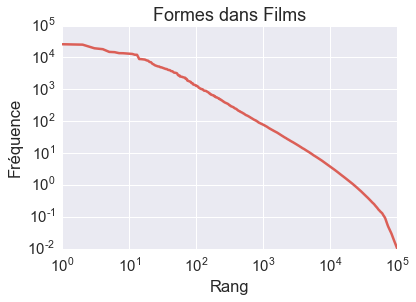

In [190]:
ax=lex3[lex3["9_freqfilms2"]>0].sort_values("rangFW").set_index("rangFW")["9_freqfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes dans Films")
None

#### Distribution de la fréquence des formes dans Textes

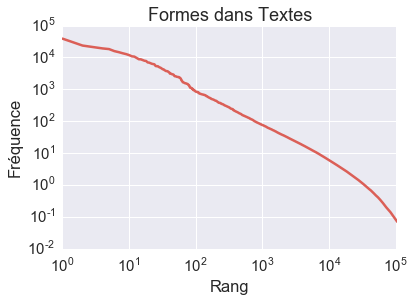

In [191]:
ax=lex3[lex3["10_freqlivres"]>0].sort_values("rangTW").set_index("rangTW")["10_freqlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes dans Textes")
None

#### Extraction des fréquences de lexèmes

In [120]:
lex3Lemmes=lex3.drop_duplicates(subset=["3_lemme","4_cgram","7_freqlemfilms2","8_freqlemlivres"]).copy()
lex3Lemmes.loc[lex3Lemmes["7_freqlemfilms2"]>0,"rangFL"]=lex3Lemmes.loc[lex3Lemmes["7_freqlemfilms2"]>0,"7_freqlemfilms2"].rank(ascending=False)
lex3Lemmes.loc[lex3Lemmes["8_freqlemlivres"]>0,"rangTL"]=lex3Lemmes.loc[lex3Lemmes["8_freqlemlivres"]>0,"8_freqlemlivres"].rank(ascending=False)
lex3Lemmes.sort_values("rangTL")

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,11_infover,rangFL,rangTL
35278,de,d2,de,PRE,NaN,NaN,25220.86,38928.92,25220.86,38928.92,NaN,3.0,1.0
75471,la,la,la,ART:def,f,s,14946.48,23633.92,14946.48,23633.92,NaN,7.0,2.0
52787,et,e,et,CON,NaN,NaN,12909.08,20879.73,12909.08,20879.73,NaN,13.0,3.0
137701,à,a,à,PRE,NaN,NaN,12190.40,19209.05,12190.40,19209.05,NaN,14.0,4.0
76448,le,l2,le,ART:def,m,s,13652.76,18310.95,13652.76,18310.95,NaN,9.0,5.0
68080,il,il,il,PRO:per,m,s,13222.93,15832.09,13222.93,15832.09,NaN,12.0,6.0
52031,es,E,être,VER,NaN,NaN,32236.50,15085.47,1849.07,256.62,ind:pre:2s;,1.0,7.0
76505,les,le,les,ART:def,NaN,p,8720.38,14662.30,8720.38,14662.30,NaN,19.0,8.0
86465,n,En,ne,ADV,NaN,NaN,22287.83,13841.89,70.36,5.68,NaN,4.0,9.0
133517,un,1,un,ART:ind,m,s,12087.62,13550.68,12087.62,13550.68,NaN,15.0,10.0


In [131]:
nbLemmes=[]
for c in categories:
    nb=lex3Lemmes[(lex3Lemmes["7_freqlemfilms2"]>0) & (lex3Lemmes["4_cgram"].isin(cgrams[c]))]["4_cgram"].count()
    nbLemmes.append(nb)

In [596]:
nbLemmes

[5359, 24381, 9387, 1360, 161, 205, 71, 35, 206]

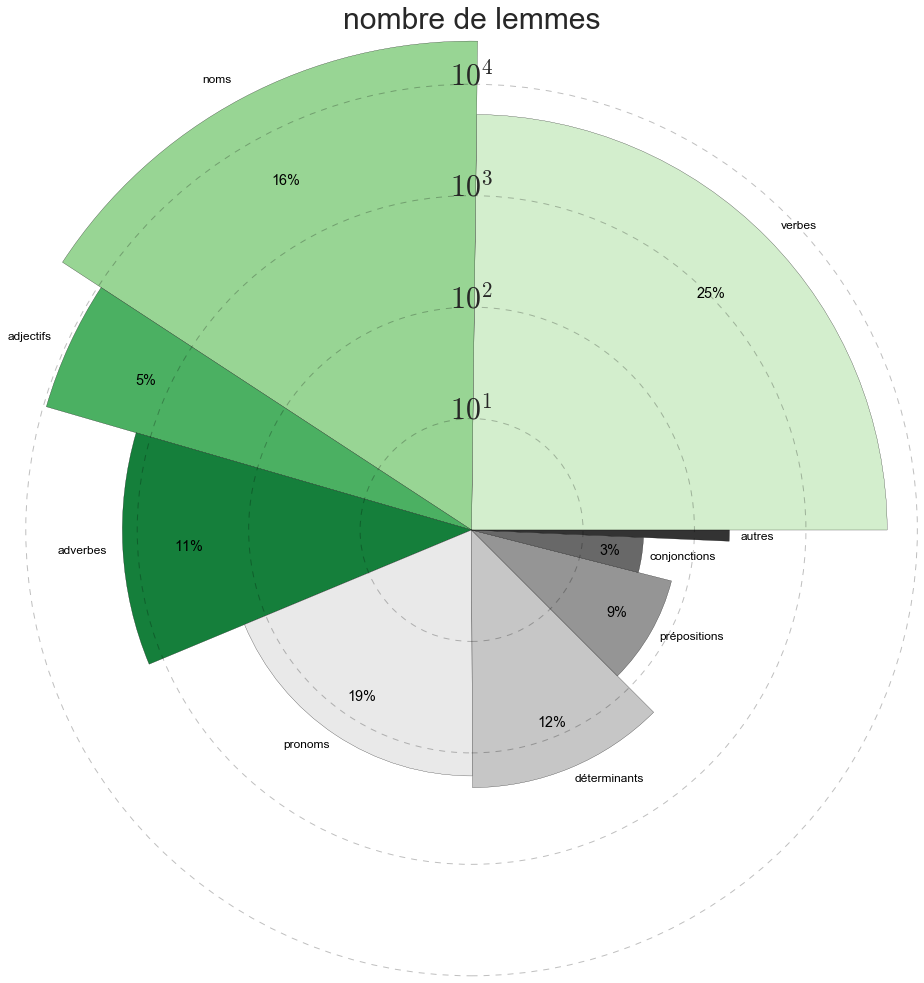

In [243]:
DFAX=pd.DataFrame(proportionsCgram,columns=["cat","prop"]).set_index("cat")
DFAX["nbLemmes"]=nbLemmes
props=DFAX["prop"].tolist()
#lemmes=[7000,12000,7000,3500,50,150,250,50,100]
heights=[]
for n,l in enumerate(nbLemmes):
    height=math.log(l,10)
    heights.append(height)
    
ax=DFAX.plot(kind="pie",y="prop",#figsize=(5,5),
             labels=DFAX.index,
#             labeldistance=5,
             autopct=lambda p: '%1d%%'%round(p) if round(p) > 1 else '',
             startangle=0,
#             pctdistance = np.mean(heights), 
             textprops=dict(color="black",),
             colors=sns.color_palette("Greens", 4)+sns.color_palette("Greys", 5),
            )
for n,wedge in enumerate(ax.patches):
    wedge.set_radius(heights[n])
nTexte=0
labAdjust=.95
pctAdjust=1.35
for text in ax.texts:
#    text.set_fontsize(32)
    if "%" not in text.get_text() and text.get_text()!="":
        x,y=text.get_position()
        text.set_position((x*heights[nTexte]*labAdjust,y*heights[nTexte]*labAdjust))
    elif text.get_text()!="":
        x,y=text.get_position()
        text.set_position((x*heights[nTexte]*pctAdjust,y*heights[nTexte]*pctAdjust))
        nTexte+=1
ax.get_legend().remove()
ax.axis('equal')
ax.annotate(r"$10^1$", xy=(0, 1), fontsize=30, ha="center",annotation_clip=False)
ax.annotate(r"$10^2$", xy=(0, 2), fontsize=30, ha="center",annotation_clip=False)
ax.annotate(r"$10^3$", xy=(0, 3), fontsize=30, ha="center",annotation_clip=False)
ax.annotate(r"$10^4$", xy=(0, 4), fontsize=30, ha="center",annotation_clip=False)
ax.annotate(u"nombre de lemmes", xy=(0, 4.5), fontsize=30, ha="center",annotation_clip=False)
#
# Attention :
#   Pour obtenir un cercle vide : fc="none", pas fc=None
#
circle1 = plt.Circle((0,0),1,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle2 = plt.Circle((0,0),2,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle3 = plt.Circle((0,0),3,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle4 = plt.Circle((0,0),4,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
fig = plt.gcf()
fig.gca().add_artist(circle1)
fig.gca().add_artist(circle2)
fig.gca().add_artist(circle3)
fig.gca().add_artist(circle4)
plt.savefig(repHDR+u'Lex3-Catégorie-FréquencePopulation.png', dpi=300, bbox_inches="tight")
plt.show()

In [178]:
DFAY=DFAX.copy()
DFAY=DFAY.append(DFAY.loc[['pronoms', u'déterminants',u'prépositions',u"conjonctions",u"autres"]].sum(), ignore_index=True).drop(DFAY.index.get_indexer(['pronoms', u'déterminants',u'prépositions',u"conjonctions",u"autres"]))
DFAY.index=u"verbes noms adjectifs adverbes grammèmes".split(" ")
DFAY

,prop,nbLemmes
verbes,0.248039,5359.0
noms,0.159714,24381.0
adjectifs,0.047332,9387.0
adverbes,0.107685,1360.0
grammèmes,0.437229,678.0


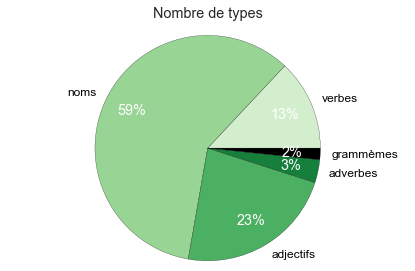

In [248]:
ax=DFAY.plot(kind="pie",y="nbLemmes",#figsize=(5,5),
             labels=DFAY.index,
#             labeldistance=5,
             autopct=lambda p: '%1d%%'%round(p) if round(p) > 1 else '',
             startangle=0,
             pctdistance = .75, 
             textprops=dict(color="black",),
             colors=sns.color_palette("Greens", 4)+["k"],
            )
for text in ax.texts:
    if "%" in text.get_text():
        text.set_color('w')
#        text.set_fontweight("heavy")
#        text.set_fontsize("large")
ax.set_title(u"Nombre de types",y=1.05)
ax.axis('equal')
ax.set(ylabel="")
ax.get_legend().remove()
plt.tight_layout()
plt.savefig(repHDR+u'Lex3-PopulationCategorie.png', dpi=300, bbox_inches="tight")
plt.show()

2.48038958521
1.59714031463
0.473315150248
1.07685152559
4.372290197


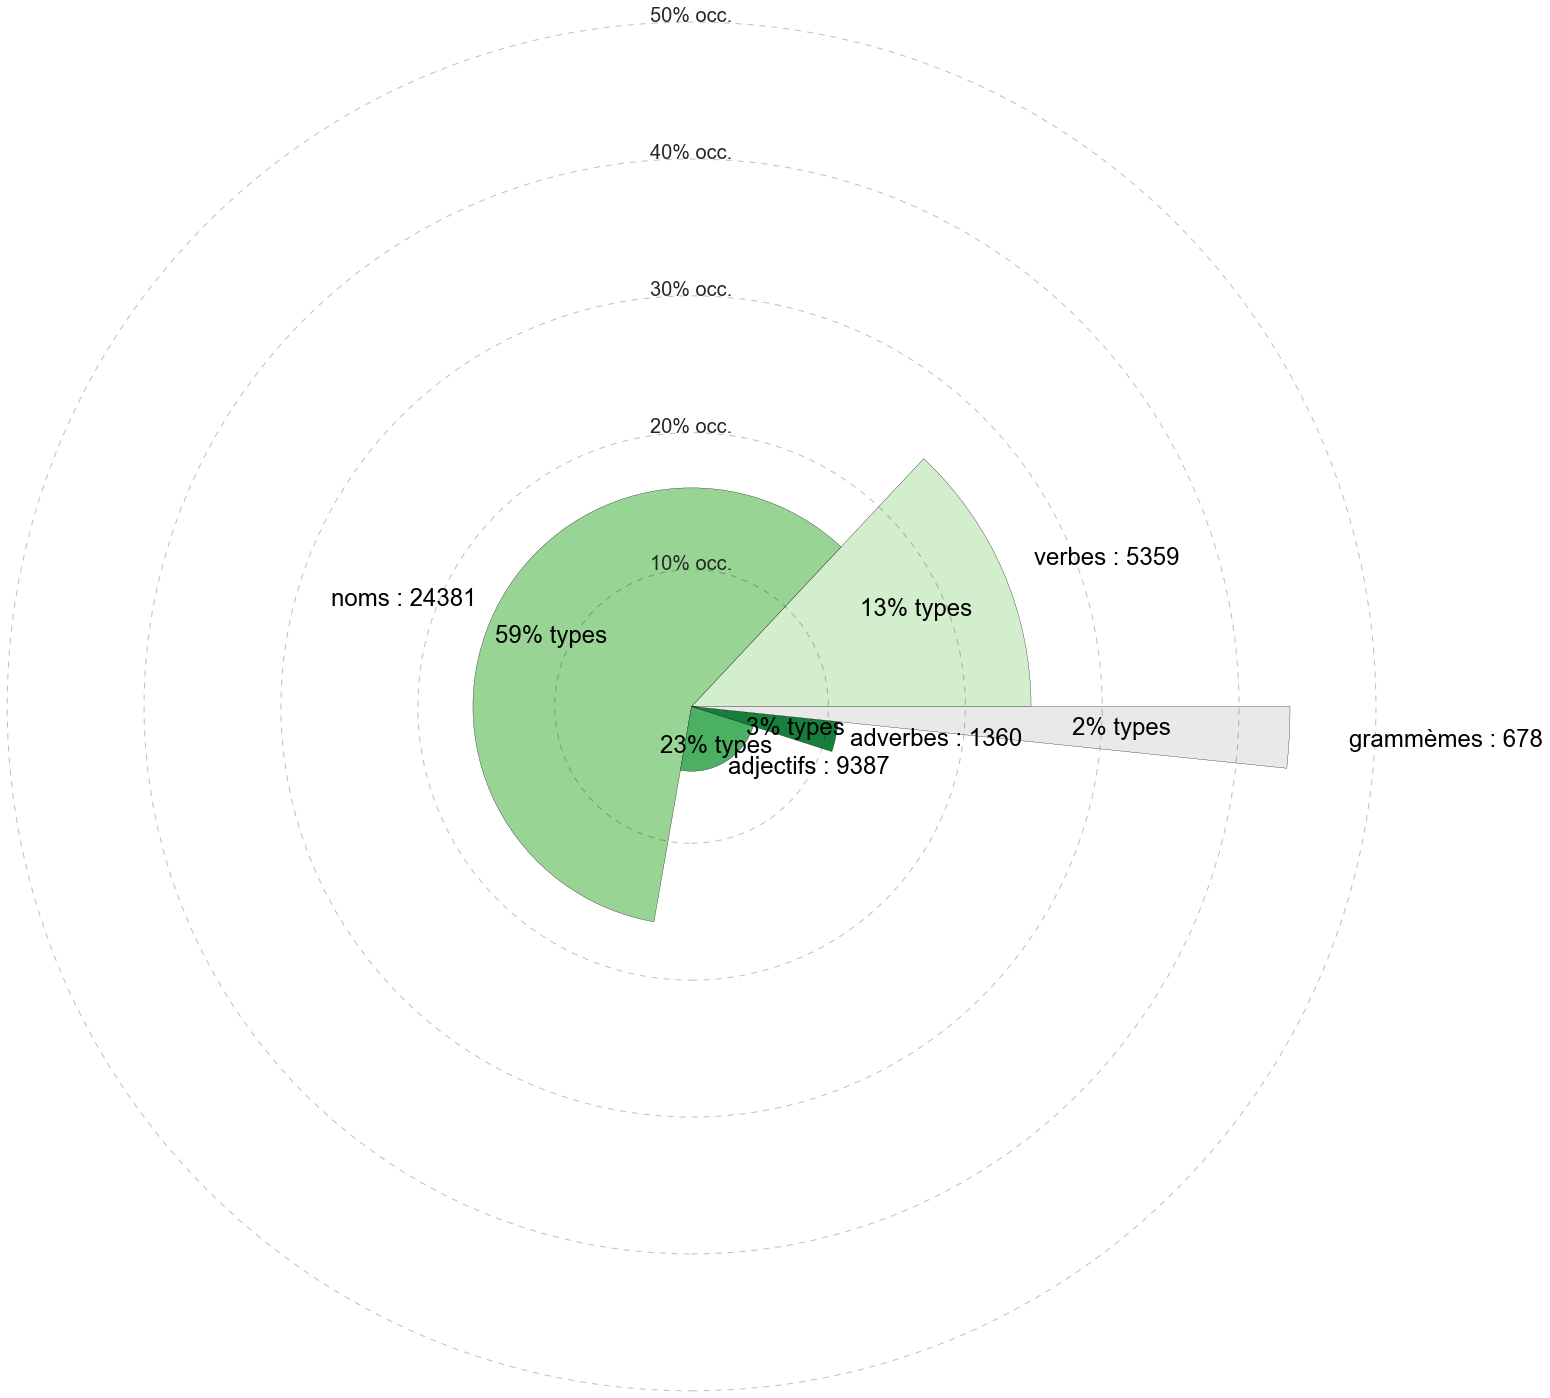

In [212]:
props=DFAY["prop"].tolist()
#lemmes=[7000,12000,7000,3500,50,150,250,50,100]
heights=[]
for n,p in enumerate(props):
    height=p*10
    print height
    heights.append(height)
    
ax=DFAY.plot(kind="pie",y="nbLemmes",figsize=(5,5),
             labels=['%s : %1d' % (l, s) for l, s in zip(DFAY.index, DFAY["nbLemmes"])],
#             labeldistance=5,
             autopct=lambda p: '%1d%% types'%round(p) if round(p) > 1 else '',
             startangle=0,
#             pctdistance = np.mean(heights), 
             textprops=dict(color="black",),
             colors=sns.color_palette("Greens", 4)+sns.color_palette("Greys", 5),
            )
for n,wedge in enumerate(ax.patches):
    wedge.set_radius(heights[n])
nTexte=0
labAdjust=1.
pctAdjust=1.2
for text in ax.texts:
    text.set_fontsize(24)
    if "%" not in text.get_text() and text.get_text()!="":
        x,y=text.get_position()
        text.set_position((x*heights[nTexte]*labAdjust,y*heights[nTexte]*labAdjust))
    elif text.get_text()!="":
        x,y=text.get_position()
        text.set_position((x*heights[nTexte]*pctAdjust,y*heights[nTexte]*pctAdjust))
        nTexte+=1
ax.get_legend().remove()
ax.axis('equal')
ax.annotate("10% occ.", xy=(0, 1), fontsize=20, ha="center",annotation_clip=False)
ax.annotate("20% occ.", xy=(0, 2), fontsize=20, ha="center",annotation_clip=False)
ax.annotate("30% occ.", xy=(0, 3), fontsize=20, ha="center",annotation_clip=False)
ax.annotate("40% occ.", xy=(0, 4), fontsize=20, ha="center",annotation_clip=False)
ax.annotate("50% occ.", xy=(0, 5), fontsize=20, ha="center",annotation_clip=False)
#ax.annotate(u"% occurrences", xy=(0, 5.5), fontsize=30, ha="center",annotation_clip=False)
#
# Attention :
#   Pour obtenir un cercle vide : fc="none", pas fc=None
#
circle1 = plt.Circle((0,0),1,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle2 = plt.Circle((0,0),2,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle3 = plt.Circle((0,0),3,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle4 = plt.Circle((0,0),4,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle5 = plt.Circle((0,0),5,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
fig = plt.gcf()
fig.gca().add_artist(circle1)
fig.gca().add_artist(circle2)
fig.gca().add_artist(circle3)
fig.gca().add_artist(circle4)
fig.gca().add_artist(circle5)
plt.savefig(repHDR+u'Lex3-Categorie-PopulationFrequence.png', dpi=300, bbox_inches="tight")
plt.show()

#### Distribution de la fréquence des lexèmes dans Films

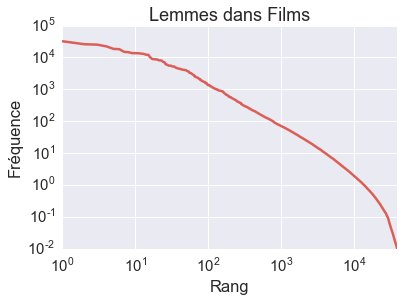

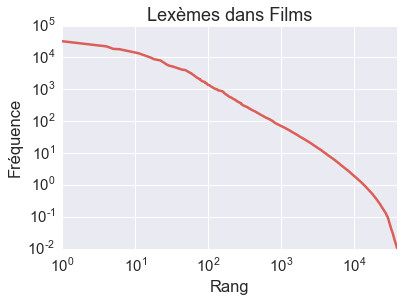

In [207]:
ax=lex3Lemmes[lex3Lemmes["7_freqlemfilms2"]>0].sort_values("rangFL").set_index("rangFL")["7_freqlemfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lemmes dans Films")
plt.show()
ax=lex3Lemmes[(lex3Lemmes["7_freqlemfilms2"]>0) &(lex3Lemmes["4_cgram"].isin(cgramLex))].sort_values("rangFL").set_index("rangFL")["7_freqlemfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes dans Films")
plt.show()

#### Distribution de la fréquence des lexèmes dans Textes

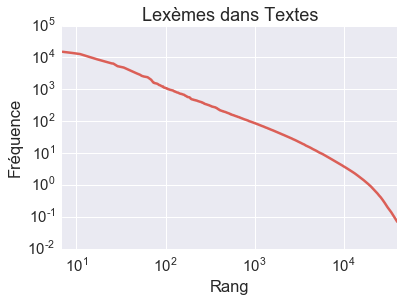

In [197]:
ax=lex3Lemmes[(lex3Lemmes["8_freqlemlivres"]>0)&(lex3Lemmes["4_cgram"].isin(cgramLex))].sort_values("rangTL").set_index("rangTL")["8_freqlemlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes dans Textes")
None

## Analyse de Verbes3

### Extraction des verbes de Lexique3

In [198]:
lex3.rename(columns={'11_infover':'lex3_11_infover'}, inplace=True)

In [199]:
verb3=lex3[lex3["4_cgram"].isin(["VER","AUX"])]

In [203]:
verb3.loc[verb3["9_freqfilms2"]>0,"rangFWV"]=verb3.loc[verb3["9_freqfilms2"]>0,"9_freqfilms2"].rank(ascending=False)
verb3.loc[verb3["10_freqlivres"]>0,"rangTWV"]=verb3.loc[verb3["10_freqlivres"]>0,"10_freqlivres"].rank(ascending=False)
verb3.sort_values("rangTWV")

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,lex3_11_infover,rangFW,rangTW,rangFWV,rangTWV
52606,est,e,être,VER,NaN,NaN,32236.50,15085.47,19417.69,6331.76,ind:pre:3s;,3.0,22.0,1.0,1.0
141534,était,etE,être,VER,NaN,NaN,32236.50,15085.47,2356.65,3688.99,ind:imp:3s;,65.0,38.0,12.0,2.0
11388,avait,avE,avoir,AUX,NaN,NaN,18559.22,12800.81,395.71,3116.42,ind:imp:3s;,262.0,41.0,78.0,3.0
1,a,a,avoir,AUX,NaN,NaN,18559.22,12800.81,6350.91,2926.69,ind:pre:3s;,22.0,46.0,2.0,4.0
37778,dit,di,dire,VER,m,s,5946.15,4832.50,2146.01,2601.62,ind:fut:3p;ind:pre:3s;ind:pas:3s;par:pas;,69.0,48.0,13.0,5.0
3774,ai,E,avoir,AUX,NaN,NaN,18559.22,12800.81,4902.10,2119.12,ind:pre:1s;,30.0,60.0,4.0,6.0
2,a,a,avoir,VER,NaN,NaN,13572.40,6426.49,5498.34,1669.39,ind:pre:3s;,25.0,64.0,3.0,7.0
52609,est,est,être,AUX,NaN,NaN,8074.24,6501.82,3318.95,1600.27,ind:pre:3s;,48.0,67.0,6.0,8.0
54981,faire,fER,faire,VER,NaN,NaN,8813.48,5328.99,2735.96,1555.14,inf;;inf;;inf;;inf;;,56.0,70.0,8.0,9.0
141533,était,etE,être,AUX,NaN,NaN,8074.24,6501.82,350.91,1497.84,ind:imp:3s;,295.0,73.0,91.0,10.0


### Graphes Fréquence=f(Rang)

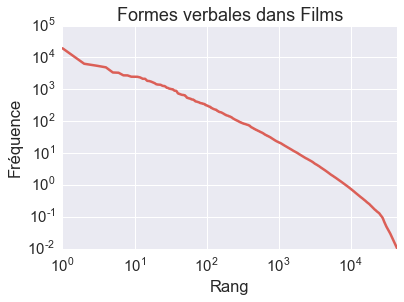

In [204]:
ax=verb3[verb3["9_freqfilms2"]>0].sort_values("rangFWV").set_index("rangFWV")["9_freqfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes verbales dans Films")
None

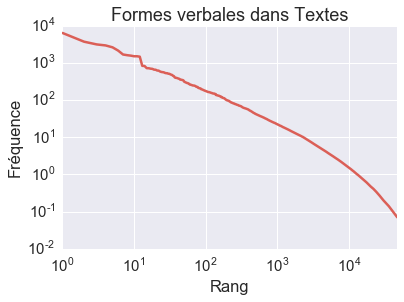

In [205]:
ax=verb3[verb3["10_freqlivres"]>0].sort_values("rangTWV").set_index("rangTWV")["10_freqlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes verbales dans Textes")
None

#### Extraction des fréquences de lexèmes

In [206]:
verb3Lemmes=verb3.drop_duplicates(subset=["3_lemme","4_cgram","7_freqlemfilms2","8_freqlemlivres"]).copy()
verb3Lemmes.loc[verb3Lemmes["7_freqlemfilms2"]>0,"rangFLV"]=verb3Lemmes.loc[verb3Lemmes["7_freqlemfilms2"]>0,"7_freqlemfilms2"].rank(ascending=False)
verb3Lemmes.loc[verb3Lemmes["8_freqlemlivres"]>0,"rangTLV"]=verb3Lemmes.loc[verb3Lemmes["8_freqlemlivres"]>0,"8_freqlemlivres"].rank(ascending=False)
verb3Lemmes.sort_values("rangTLV")

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,lex3_11_infover,rangFW,rangTW,rangFWV,rangTWV,rangFLV,rangTLV
52031,es,E,être,VER,NaN,NaN,32236.50,15085.47,1849.07,256.62,ind:pre:2s;,75.0,330.0,15.0,62.0,1.0,1.0
1,a,a,avoir,AUX,NaN,NaN,18559.22,12800.81,6350.91,2926.69,ind:pre:3s;,22.0,46.0,2.0,4.0,2.0,2.0
52030,es,E,être,AUX,NaN,NaN,8074.24,6501.82,539.36,77.70,ind:pre:2s;,207.0,975.5,55.0,256.5,6.0,3.0
2,a,a,avoir,VER,NaN,NaN,13572.40,6426.49,5498.34,1669.39,ind:pre:3s;,25.0,64.0,3.0,7.0,3.0,4.0
54981,faire,fER,faire,VER,NaN,NaN,8813.48,5328.99,2735.96,1555.14,inf;;inf;;inf;;inf;;,56.0,70.0,8.0,9.0,5.0,5.0
36795,dira,diRa,dire,VER,NaN,NaN,5946.15,4832.50,36.47,21.89,ind:fut:3s;,1847.0,3335.5,672.5,1022.5,7.0,6.0
3949,aille,aj,aller,VER,NaN,NaN,9992.77,2854.93,89.81,36.55,sub:pre:1s;sub:pre:3s;,864.0,2047.5,304.0,584.5,4.0,7.0
95017,peut,p2,pouvoir,VER,NaN,NaN,5524.47,2659.80,1209.64,508.99,ind:pre:3s;,106.0,170.0,27.0,30.0,8.0,8.0
135009,verra,vERa,voir,VER,NaN,NaN,4119.43,2401.76,78.66,26.28,ind:fut:3s;,987.0,2795.5,359.0,828.0,11.0,9.0
117363,sachant,saS@,savoir,VER,NaN,NaN,4516.71,2003.58,14.39,34.59,par:pre;,3828.5,2171.0,1381.5,624.0,10.0,10.0


#### Distribution de la fréquence des lexèmes dans Films

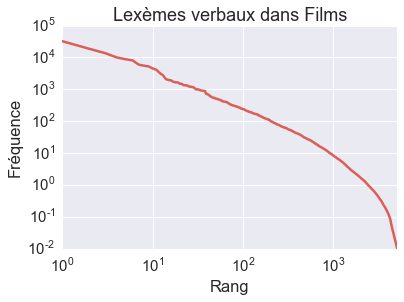

In [208]:
ax=verb3Lemmes[verb3Lemmes["7_freqlemfilms2"]>0].sort_values("rangFLV").set_index("rangFLV")["7_freqlemfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes verbaux dans Films")
None

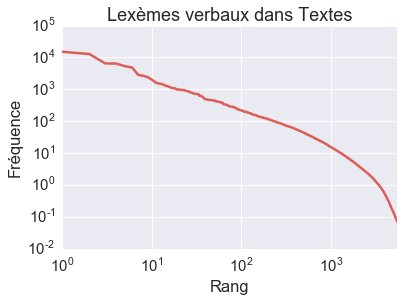

In [209]:
ax=verb3Lemmes[verb3Lemmes["8_freqlemlivres"]>0].sort_values("rangTLV").set_index("rangTLV")["8_freqlemlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes verbaux dans Textes")
None

In [70]:
pseudoZipfFilms=verb3Lemmes.sort_values("rangFLV").set_index("rangFLV")[["7_freqlemfilms2"]]
pseudoZipfLivres=verb3Lemmes.sort_values("rangTLV").set_index("rangTLV")[["8_freqlemlivres"]]

In [71]:
pseudoZipfFilms=pseudoZipfFilms[pseudoZipfFilms["7_freqlemfilms2"]>0]
pseudoZipfFilms.drop_duplicates(inplace=True)
pseudoZipfFilms.reset_index(inplace=True)
pseudoZipfFilms

,rangFLV,7_freqlemfilms2
0,1.0,32236.50
1,2.0,13572.40
2,3.0,9992.77
3,4.0,8813.48
4,5.0,5946.15
5,6.0,5524.47
6,7.0,5249.30
7,8.0,4516.71
8,9.0,4119.43
9,10.0,3232.57


In [82]:
pseudoZipfFilms["logFreq"]=pseudoZipfFilms["7_freqlemfilms2"].apply(math.log)
pseudoZipfFilms["logRank"]=pseudoZipfFilms["rangFLV"].apply(math.log)
coefs=[1.5,1.6,1.7,1.8,1.9]
for c in coefs:
    pseudoZipfFilms[c]=pseudoZipfFilms["logFreq"]+c*pseudoZipfFilms["logRank"]

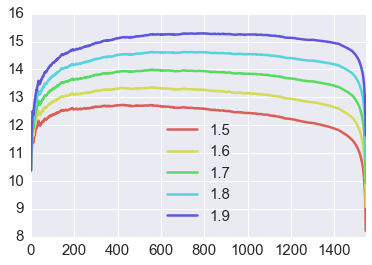

In [83]:
pseudoZipfFilms[coefs].plot()

# TESTS 
## Examen de la distribution des échantillons

In [23]:
import pickle

In [24]:
nomSample="/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/Longitudinales/Longitudinal-55-T1100000-F41134.pkl"

In [26]:
with open(nomSample,"rb") as input:
    dfSample=pickle.load(input)
dfSample["rang"]=dfSample.tir1.rank(ascending=False)

ImportError: No module named indexes.base

In [ ]:
ax=dfSample.sort_values("rang").set_index("rang")["tir1"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Formes verbales")
None

In [ ]:
lexemesSample=dfSample.groupby("lexeme")[["tir1"]].sum()
lexemesSample["rang"]=lexemesSample.tir1.rank(ascending=False)

In [ ]:
ax=lexemesSample.sort_values("rang").set_index("rang")["tir1"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Verbes")
None

# Projet de thèse Gauvain

In [ ]:
lex3[lex3["7_freqlemfilms2"]>=.1].groupby("3_lemme").count()

In [ ]:
for seuil in [100, 10, 1, 0.1, 0.01]:
    print "seuil",seuil
    dfFilms=lex3[lex3["7_freqlemfilms2"]>=seuil].groupby("3_lemme")
    countFilms=dfFilms.count()
    print "\tFilms"
#    print "\tTextes",lex3[(lex3["8_freqlemlivres"]>=seuil)].groupby("3_lemme").count().shape
#    print "\tLex3",lex3[(lex3["7_freqlemfilms2"]>=seuil)|(lex3["8_freqlemlivres"]>=seuil)].groupby("3_lemme").count().shape

In [ ]:
lex3.groupby("3_lemme").count()

In [14]:
lex3[(lex3["7_freqlemfilms2"]>100)].groupby("3_lemme").count().shape[0]

705

In [15]:
lex3[lex3["7_freqlemfilms2"]>=10].groupby("3_lemme").count().shape[0]

3676

In [16]:
lex3[lex3["7_freqlemfilms2"]>=1].groupby("3_lemme").count().shape[0]

12486

In [7]:
lex3[lex3["7_freqlemfilms2"]>=0.1].groupby("3_lemme").count().shape[0]

26345

In [8]:
lex3[lex3["7_freqlemfilms2"]>=0.01].groupby("3_lemme").count().shape[0]

37630

In [9]:
lex3[(lex3["8_freqlemlivres"]>100)].groupby("3_lemme").count().shape[0]

806

In [10]:
lex3[(lex3["8_freqlemlivres"]>10)].groupby("3_lemme").count().shape[0]

5147

In [11]:
lex3[(lex3["8_freqlemlivres"]>1)].groupby("3_lemme").count().shape[0]

18070

In [12]:
lex3[(lex3["8_freqlemlivres"]>0.1)].groupby("3_lemme").count().shape[0]

32888

In [13]:
lex3[(lex3["8_freqlemlivres"]>0.01)].groupby("3_lemme").count().shape[0]

40120

# Hart & Risley
Dans leur étude, Hart et Risley proposent que l'exposition des enfants varient d'un milieu social à un autre en terme de mots adressés à l'enfant entre 600 et 2000 mots par heure avec 5 heures de communication par jour.

Avec cet ordre de grandeur, on peut estimer une fourchette du nombre de tokens perçu au cours du temps :
 - fourchette basse : 150M de mots en 12 ans
 - fouchette haute : 520M de mots en 12 ans

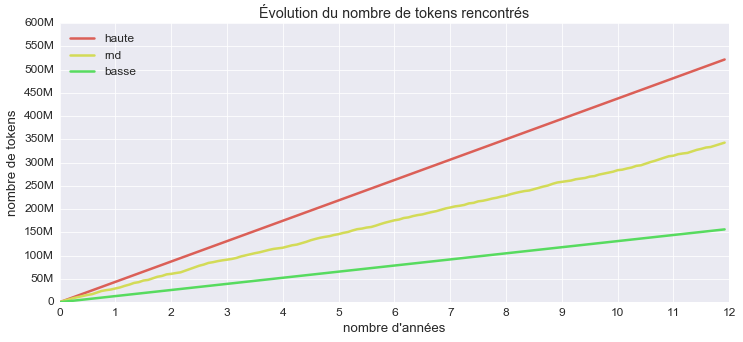

,haute,rnd,basse
11,40.1M,27.2M,12M
23,83.9M,59.9M,25.2M
35,128M,90.1M,38.3M
47,172M,116M,51.5M
59,215M,145M,64.6M
71,259M,174M,77.7M
83,303M,202M,90.9M
95,347M,227M,104M
107,391M,257M,117M
119,434M,281M,130M


In [521]:
estBasse=600
estHaute=2000
journee=5
periode=journee*30
nbPoints=12*12
serieBasse=[i*annee*estBasse for i in range(nbPoints)]
serieHaute=[i*annee*estHaute for i in range(nbPoints)]
#print serieBasse,serieHaute
serieRnd=[]
sumRnd=0
for i in range(nbPoints):
    serieRnd.append(sumRnd)
    rnd=np.random.rand()
    elementRnd=estBasse*annee*rnd+estHaute*annee*(1-rnd)
    sumRnd+=elementRnd
estimationsHR=pd.DataFrame(serieBasse,columns=["basse"])
estimationsHR["haute"]=serieHaute
estimationsHR["rnd"]=serieRnd
estimationsHR=estimationsHR[["haute","rnd","basse"]]
ax=estimationsHR.plot(kind="line",title=u"Nombre de tokens",figsize=(12,5))
ax.set(yscale="linear",
       xlabel=u"nombre d'années",ylabel=u"nombre de tokens",title=u"Évolution du nombre de tokens rencontrés"
      )

ax.xaxis.set_ticks(np.linspace(0,144,num=13))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(Mois2Annees))

ax.yaxis.set_ticks(np.linspace(0,600000000,num=13))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))
plt.show()

sampleAnnees=[(i+1)*12-1 for i in range(12)]
estimationsHR.loc[sampleAnnees,:].apply(roundTable)

# Tests de correspondances entre tokens et vocabulaire

Il faut faire le calcul au niveau des formes et des lemmes. Pour les lemmes, on peut faire une estimation du pourcentage d'une catégorie par tranche de facteur 10 et de même pour les formes :
- verbes :
 - formes : 
 - lemmes : .21,.27,.19,.13,.13
  - la queue de la distribution est problématique...
- noms :
 - formes : 
 - lemmes :
- adjectifs :
 - formes : 
 - lemmes :



In [588]:
def getCatSize(catDist,uniques):
    result=0
    for u in sorted(uniques):
        if u<=100:
            if np.random.rand()<=catDist[0]:
                result+=1
        elif u<=1000:
            if np.random.rand()<=catDist[1]:
                result+=1
        elif u<=10000:
            if np.random.rand()<=catDist[2]:
                result+=1
        elif u<=100000:
            if np.random.rand()<=catDist[3]:
                result+=1
        elif u<=1000000:
            if np.random.rand()<=catDist[4]:
                result+=1
    return result

In [589]:
def getZipfSizeTable(coefs,tokenNumbers,catDist):
    locCatZipfSizes={}
    locZipfSizes={}
    for coef in coefs:
        if coef not in locZipfSizes:
            locZipfSizes[coef]={}
            locCatZipfSizes[coef]={}
        for nbTokens in tokenNumbers:
            zipf=np.random.zipf(coef,nbTokens)
            uniques=np.unique(zipf)
            zipfSize=len(uniques)
            locZipfSizes[coef][nbTokens]=zipfSize
            catSize=getCatSize(catDist,uniques)
            locCatZipfSizes[coef][nbTokens]=catSize
            print coef,math.log(nbTokens,10),math.log(zipfSize,10), math.log(catSize,10)
            print datetime.now().strftime('%H:%M:%S') 
    return locZipfSizes,locCatZipfSizes

In [ ]:
coefs=[1+(i+1)/100. for i in range(20)]
tokenNumbers=[int(1E5*(i+1)) for i in range(9)]+[int(1E6*(i+1)) for i in range(9)]+[int(1E7*(i+1)) for i in range(9)]+[int(1E8*(i+1)) for i in range(5)]

In [610]:
sPrev=0
for i in range(1,6):
    sNow=lex3[(lex3["4_cgram"].isin(cgramV))&(lex3["9_freqfilms2"]>0)&(lex3["rangFW"]<=10**(i+1))].count()["1_ortho"]
    print 10**(i+1),(sNow-sPrev)/10.**(i+1)*100

100 24.0
1000 36.7
10000 37.09
100000 40.224
1000000 4.837


In [562]:
lex3Lemmes[(lex3Lemmes["4_cgram"].isin(cgramV))&(lex3Lemmes["7_freqlemfilms2"]>0)&(lex3Lemmes["rangFL"]<=100000)].count()

1_ortho            5359
2_phon             5359
3_lemme            5359
4_cgram            5359
5_genre             440
6_nombre            440
7_freqlemfilms2    5359
8_freqlemlivres    5359
9_freqfilms2       5359
10_freqlivres      5359
11_infover         5359
rangFL             5359
rangTL             4830
dtype: int64

In [612]:
vCatDistLemmes=[.21,.27,.19,.03,.001]
vCatDistMots=[.24,.367,.37,.402,.048]

In [613]:
dictZipfSize,dictCatZipfSizeMots=getZipfSizeTable(coefs,tokenNumbers,vCatDistMots)

1.01 5.0 4.90639969622 3.5962671264
15:59:49
1.01 5.30102999566 5.19848938392 3.82988244644
15:59:49
1.01 5.47712125472 5.36919172927 3.96085115372
15:59:50
1.01 5.60205999133 5.49104916958 4.04871363808
15:59:50
1.01 5.69897000434 5.5849550744 4.11320776982
15:59:50
1.01 5.77815125038 5.66190350887 4.16893921384
15:59:51
1.01 5.84509804001 5.72681519974 4.20862943832
15:59:52
1.01 5.90308998699 5.78318153625 4.25309558585
15:59:52
1.01 5.95424250944 5.83260661797 4.28162415144
15:59:53
1.01 6.0 5.87651631546 4.31024710843
15:59:54
1.01 6.30102999566 6.16876139779 4.48059614818
15:59:56
1.01 6.47712125472 6.33918700766 4.563955465
15:59:58
1.01 6.60205999133 6.46034688617 4.61511852333
16:00:02
1.01 6.69897000434 6.55419298771 4.65412839126
16:00:06
1.01 6.77815125038 6.63082201923 4.68635916176
16:00:11
1.01 6.84509804001 6.69573596201 4.70078157173
16:00:17
1.01 6.90308998699 6.75174718127 4.71949701661
16:00:24
1.01 6.95424250944 6.80161799142 4.73510364945
16:00:32
1.01 7.0 6.84555

1.05 7.77815125038 7.42642130267 4.90367046775
17:36:25
1.05 7.84509804001 7.48955043046 4.90755645969
17:37:03
1.05 7.90308998699 7.54433201516 4.90993025975
17:37:46
1.05 7.95424250944 7.59251986997 4.91292847272
17:38:35
1.05 8.0 7.63573168632 4.91377148012
17:39:30
1.05 8.30102999566 7.91958862191 4.92117125797
17:41:16
1.05 8.47712125472 8.08562567287 4.91854405287
17:43:53
1.05 8.60205999133 8.20337390828 4.91794640704
17:47:30
1.05 8.69897000434 8.29469769193 4.9175212636
17:51:55
1.06 5.0 4.77041749987 3.72542155007
17:51:55
1.06 5.30102999566 5.05039135792 3.94413707316
17:51:55
1.06 5.47712125472 5.21883473446 4.06654953876
17:51:55
1.06 5.60205999133 5.33495209952 4.14578667017
17:51:56
1.06 5.69897000434 5.42520968259 4.21125406762
17:51:56
1.06 5.77815125038 5.50061377922 4.26100102334
17:51:56
1.06 5.84509804001 5.56370055037 4.29830713733
17:51:57
1.06 5.90308998699 5.61820608837 4.33595910615
17:51:57
1.06 5.95424250944 5.66527791095 4.36595572267
17:51:58
1.06 6.0 5.70

1.1 6.77815125038 6.24818937837 4.70959216936
18:51:43
1.1 6.84509804001 6.30912980197 4.72609935061
18:51:46
1.1 6.90308998699 6.36139878053 4.74389371823
18:51:50
1.1 6.95424250944 6.40781988767 4.75541746281
18:51:54
1.1 7.0 6.44966765788 4.76376481553
18:51:58
1.1 7.30102999566 6.72294826098 4.82932950804
18:52:06
1.1 7.47712125472 6.88263449218 4.86157622537
18:52:18
1.1 7.60205999133 6.99606453903 4.88236513458
18:52:34
1.1 7.69897000434 7.08409106268 4.8950964265
18:52:54
1.1 7.77815125038 7.15599160043 4.89924032647
18:53:17
1.1 7.84509804001 7.21692639982 4.9082275829
18:53:44
1.1 7.90308998699 7.26927896926 4.90943299737
18:54:15
1.1 7.95424250944 7.31594315399 4.91159967131
18:54:50
1.1 8.0 7.35734281266 4.9142585117
18:55:28
1.1 8.30102999566 7.63065601802 4.92187367587
18:56:39
1.1 8.47712125472 7.79038336542 4.92023814859
18:58:26
1.1 8.60205999133 7.90385064412 4.91908855718
19:00:44
1.1 8.69897000434 7.99172766638 4.92201402322
19:03:38
1.11 5.0 4.59563949332 3.73599788

1.15 5.77815125038 5.13469973201 4.20978301485
19:44:44
1.15 5.84509804001 5.19308283726 4.26014296909
19:44:44
1.15 5.90308998699 5.24264079782 4.29666519026
19:44:44
1.15 5.95424250944 5.28841691763 4.32727717714
19:44:44
1.15 6.0 5.32770214684 4.34764220473
19:44:45
1.15 6.30102999566 5.58892909514 4.49869642186
19:44:46
1.15 6.47712125472 5.74248789304 4.57854752863
19:44:46
1.15 6.60205999133 5.85148828041 4.62263878114
19:44:48
1.15 6.69897000434 5.93610036286 4.65612696228
19:44:49
1.15 6.77815125038 6.00473053578 4.67884602484
19:44:51
1.15 6.84509804001 6.06329469489 4.70014968169
19:44:53
1.15 6.90308998699 6.11336301456 4.71470687881
19:44:56
1.15 6.95424250944 6.15737274201 4.729674948
19:44:59
1.15 7.0 6.19733983872 4.73674698388
19:45:02
1.15 7.30102999566 6.4597268261 4.80475941029
19:45:08
1.15 7.47712125472 6.61297035145 4.83799855182
19:45:17
1.15 7.60205999133 6.72129005648 4.86178523756
19:45:28
1.15 7.69897000434 6.80534410326 4.87406994144
19:45:43
1.15 7.77815125

1.19 8.30102999566 7.09749515184 4.91253557094
20:22:07
1.19 8.47712125472 7.24566960237 4.91876403103
20:23:16
1.19 8.60205999133 7.35075859575 4.91767352328
20:24:48
1.19 8.69897000434 7.43220283036 4.91799361952
20:26:42
1.2 5.0 4.29043531367 3.62838893005
20:26:42
1.2 5.30102999566 4.53797012776 3.83922657401
20:26:42
1.2 5.47712125472 4.68844651961 3.95636055367
20:26:42
1.2 5.60205999133 4.79106576982 4.03342375549
20:26:43
1.2 5.69897000434 4.87226119028 4.09659720836
20:26:43
1.2 5.77815125038 4.93943937502 4.14749082079
20:26:43
1.2 5.84509804001 4.99240327809 4.18737969324
20:26:43
1.2 5.90308998699 5.04348802835 4.22354785591
20:26:43
1.2 5.95424250944 5.0850192825 4.25331376947
20:26:44
1.2 6.0 5.12344981437 4.27625494802
20:26:44
1.2 6.30102999566 5.37360705375 4.4402634548
20:26:44
1.2 6.47712125472 5.52066821601 4.51706387348
20:26:45
1.2 6.60205999133 5.62471411221 4.57141765213
20:26:46
1.2 6.69897000434 5.705623416 4.60545589147
20:26:48
1.2 6.77815125038 5.7720545921

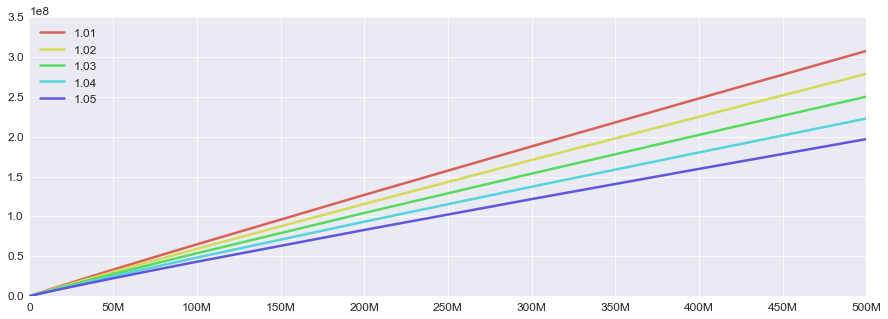

In [623]:
samples=[1.8,1.9,2.0,2.1,2.2]
samples=[1+(i+1)/100. for i in range(5)]
dfZipfSizes=pd.DataFrame.from_dict(dictZipfSize)
ax=dfZipfSizes[samples].plot(figsize=(15,5))
#ax.set(yscale="log")
ax.xaxis.set_ticks(np.linspace(0,500000000,num=11))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))



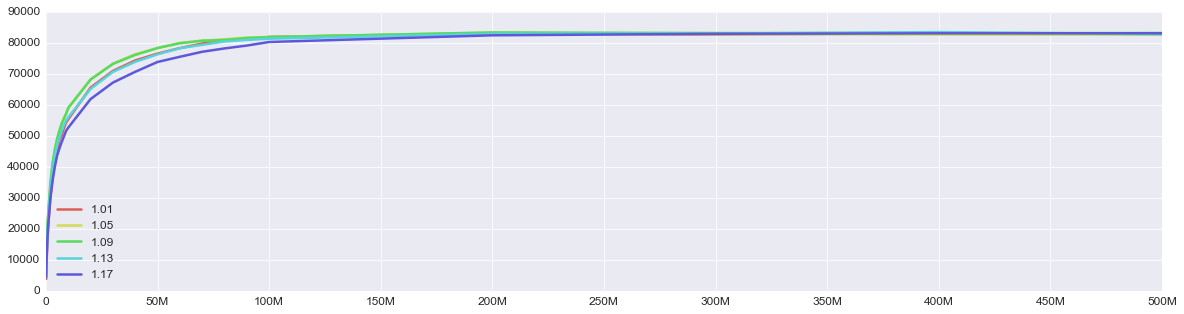

In [627]:
samples=[1.8,1.9,2.0,2.1,2.2]
samples=[1+(4*i+1)/100. for i in range(5)]
dfCatZipfSizes=pd.DataFrame.from_dict(dictCatZipfSizeMots)
ax=dfCatZipfSizes[samples].plot(figsize=(20,5))
#ax.set(yscale="log")
ax.xaxis.set_ticks(np.linspace(0,500000000,num=11))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))



In [496]:
def roundElement(x):
    text="0"
    if x!=0:
        magnitude=int(np.log10(x))
        x=round(float(x)/(10**magnitude),2)*10**magnitude
        if magnitude>9:
            unit="G"
            value=("%.1f"%(float(x)/1e9)).strip("0").strip(".")
        elif magnitude==9:
            unit="G"
            value=("%.2f"%(float(x)/1e9)).strip("0").strip(".")
        elif magnitude>6:
            unit="M"
            value=("%.1f"%(float(x)/1e6)).strip("0").strip(".")
        elif magnitude==6:
            unit="M"
            value=("%.2f"%(float(x)/1e6)).strip("0").strip(".")
        elif magnitude>3:
            unit="k"
            value=("%.1f"%(float(x)/1e3)).strip("0").strip(".")
        elif magnitude==3:
            unit="k"
            value=("%.2f"%(float(x)/1e3)).strip("0").strip(".")
        elif magnitude>0:
            unit=""
            value=("%.1f"%float(x)).strip("0").strip(".")
        else:
            unit=""
            value=x
        text="%s%s"%(value,unit)
    return text


In [510]:
roundElement(1453.756468)

'1.45k'

In [503]:
def roundTable(series):
    result=series.copy()
    for ix,el in result.iteritems():
        result.loc[ix]=roundElement(el)
    return result

In [629]:
print dfZipfSizes.loc[100000000:,samples].apply(roundTable).to_latex()

\begin{tabular}{llllll}
\toprule
{} &  1.01 &   1.05 &   1.09 &   1.13 &   1.17 \\
\midrule
100000000 &   65M &  43.2M &    26M &  15.2M &     9M \\
200000000 &  127M &  83.1M &  49.1M &  28.1M &  16.3M \\
300000000 &  188M &   122M &  71.1M &  40.2M &    23M \\
400000000 &  248M &   160M &  92.5M &  51.9M &  29.5M \\
500000000 &  308M &   197M &   113M &  63.2M &  35.6M \\
\bottomrule
\end{tabular}



In [630]:
print dfCatZipfSizes.loc[100000000:,samples].apply(roundTable).to_latex()

\begin{tabular}{llllll}
\toprule
{} &   1.01 &   1.05 &   1.09 &   1.13 &   1.17 \\
\midrule
100000000 &    82k &    82k &    82k &  81.5k &  80.4k \\
200000000 &  83.2k &  83.4k &  83.5k &    83k &  82.5k \\
300000000 &  82.8k &  82.9k &  83.3k &  83.1k &    83k \\
400000000 &  83.2k &  82.8k &  83.3k &  83.6k &  83.2k \\
500000000 &  83.1k &  82.7k &  83.3k &  82.9k &  83.2k \\
\bottomrule
\end{tabular}



In [628]:
dfZipfSizes.to_csv(path_or_buf="ZipfCoefTokensTypes.csv",sep="\t",encoding="utf8")
dfCatZipfSizes.to_csv(path_or_buf="ZipfCoefTokensTypes-Verbes.csv",sep="\t",encoding="utf8")